In [1]:
# !pip install -Uqq fastbook

In [2]:
# from fastbook import *
from fastai.tabular.all import *

import os
import zipfile

import json
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import numpy as np
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import GradientBoostingClassifier

Custom metrics.

In [3]:
def macro_averaged_mean_absolute_error(y_true, y_pred):
    labels = unique_labels(y_true, y_pred)
    mae = []
    for possible_class in labels:
        indices = np.flatnonzero(y_true == possible_class)
        mae.append(metrics.mean_absolute_error(y_true[indices], y_pred[indices],))

    return np.sum(mae) / len(mae)

def calculate_metrics(y_pred, y_true):
    y_true = y_true + 1 
    y_pred = y_pred + 1
    
    if np.in1d(y_pred, y_true, invert=True).sum() > 0:
        raise ValueError("There are non-existent labels in predictions")

    weights = np.array([1.0, 1.0, 1.5, 1.5, 1.5])
    recall_multi = metrics.recall_score(y_true, y_pred, average=None)
    weighted_accuracy = np.sum(np.multiply(recall_multi, weights)) / np.sum(weights)
    mamae = macro_averaged_mean_absolute_error(y_true, y_pred)
    
    return weighted_accuracy - 0.25 * mamae

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(24)

Extracting data to current directory.

In [5]:
with zipfile.ZipFile('data_train.zip', 'r') as zip_obj:
    zip_obj.extractall()
with zipfile.ZipFile('data_test.zip', 'r') as zip_obj:
    zip_obj.extractall()
with open("data_test/data_test.json", "r") as fin:
    data_test = json.load(fin)
with open("data_train/data_train.json", "r") as fin:
    data_train = json.load(fin)

targets_train = pd.read_csv("data_train/targets_train.csv", index_col=0)

Below is a function for calculating the area of predicted object.

In [6]:
def area(k):
    return (k[2] - k[0]) * (k[3] - k[1])

Extracting data features from json file to pandas dataframe. 

The data describes different objects mainly by bounding box coordinates and probability of belonging to a particular type.

Since the data isn't a ground truth but noisy predictions of 3 different models, it might be useful to use a threshold for the probability to filter it. 

In [7]:
def extract_basic_features(breast):
    predictors = {}
    thresh = 0.65
    for key in ["tissue_density_predicted", "cancer_probability_predicted", "laterality"]:
        predictors[key] = breast[key]
    
    view = ['CC', 'MLO']    
    object_type = ['fibrocystic_breast_changes', 'mass_benign', 'artifact', 'lymphonodus', 
                    'calcinates_benign', 'calcified vessels', 'mass_malignant', 
                    'pectoral muscle', 'skin_thickening', 'papilloma', 'calcified cyst', 'calcinates_malignant']
                    
    model_number = [1, 2, 3]
    
    # functions to apply to the features
    func = [max, np.mean, np.median, len]
    
    # column_name = view + object_type + model_number + function_name
    for v in view:
        for ob in object_type:
            for m in model_number:
                for f in func:
                    predictors['{}_{}_model_{}_{}'.format(v, ob, m, f.__name__)] = 0.0
                    if f.__name__ != 'len':
                        predictors['area_{}_{}_model_{}_{}'.format(v, ob, m, f.__name__)] = 0.0
                    
                    # probability info
                    prob_list = [obj['probability'] for obj in breast[v] if 
                                (ob in obj["object_type"] and 
                                 obj["probability"] >= thresh and 
                                 obj['model_number'] == m)]
                    
                    # bounding box area info
                    area_list = [area(obj["coordinates"]) for obj in breast[v] if 
                                (ob in obj["object_type"] and 
                                 obj["probability"] >= thresh and 
                                 obj['model_number'] == m)]
                    
                    if prob_list:
                        predictors['{}_{}_model_{}_{}'.format(v, ob, m, f.__name__)] = f(prob_list)
                    if area_list and f.__name__ != 'len':
                        predictors['area_{}_{}_model_{}_{}'.format(v, ob, m, f.__name__)] = f(area_list)
    
    return predictors

In [8]:
predictors = {}
for key, value in data_train.items():
    predictors[key] = extract_basic_features(value)

Creating data frame for training.

In [9]:
df_train = pd.DataFrame.from_dict(predictors, orient="index")
df_train = pd.merge(df_train, targets_train, left_index=True, right_index=True)
df_train['laterality'] = df_train['laterality'].map(lambda lat: 0 if lat == "L" else 1)

In [10]:
df_train.describe()

,tissue_density_predicted,cancer_probability_predicted,laterality,CC_fibrocystic_breast_changes_model_1_max,area_CC_fibrocystic_breast_changes_model_1_max,CC_fibrocystic_breast_changes_model_1_mean,area_CC_fibrocystic_breast_changes_model_1_mean,CC_fibrocystic_breast_changes_model_1_median,area_CC_fibrocystic_breast_changes_model_1_median,CC_fibrocystic_breast_changes_model_1_len,...,area_MLO_calcinates_malignant_model_2_median,MLO_calcinates_malignant_model_2_len,MLO_calcinates_malignant_model_3_max,area_MLO_calcinates_malignant_model_3_max,MLO_calcinates_malignant_model_3_mean,area_MLO_calcinates_malignant_model_3_mean,MLO_calcinates_malignant_model_3_median,area_MLO_calcinates_malignant_model_3_median,MLO_calcinates_malignant_model_3_len,BiRads
count,4063.000000,4063.000000,4063.000000,4063.000000,4.063000e+03,4063.000000,4.063000e+03,4063.000000,4.063000e+03,4063.000000,...,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000,4063.000000
mean,1.914841,0.483126,0.505784,0.162759,1.122747e+05,0.162467,1.118266e+05,0.162473,1.118006e+05,0.221265,...,19.326114,0.003200,0.000361,203.948806,0.000361,203.948806,0.000361,203.948806,0.000492,1.684962
std,0.828549,0.364314,0.500028,0.312249,2.943068e+05,0.311649,2.940667e+05,0.311663,2.940669e+05,0.429146,...,366.517647,0.056481,0.016327,12886.023784,0.016327,12886.023784,0.016327,12886.023784,0.022184,0.591411
min,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.116000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.000000,0.440000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,2.000000,0.867000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,4.000000,1.000000,1.000000,0.969200,1.696856e+06,0.969200,1.696856e+06,0.969200,1.696856e+06,3.000000,...,12992.000000,1.000000,0.798900,821346.000000,0.798900,821346.000000,0.798900,821346.000000,1.000000,5.000000


Removing unfilled columns by checking the maximum value of each column.

In [11]:
max_value = df_train.describe().iloc[-1]
for elem in df_train.columns:
    if max_value[elem] == 0.0:
        df_train = df_train.drop([elem], axis=1)

Split the data to train and validation sets.

In [12]:
splits = TrainTestSplitter(test_size=0.2,
                           random_state=24, 
                           stratify=df_train["BiRads"], 
                           shuffle=True)(range_of(df_train))

In [13]:
splits

((#3250) [3352,3043,3739,1967,1840,183,3734,2353,2067,1524...],
 (#813) [2623,3462,3674,1621,3677,1936,643,891,464,2772...])

Make sure both sets contain a data of each class.

In [14]:
df_train.iloc[splits[0]].BiRads.unique()

array([2, 1, 4, 3, 5])

In [15]:
df_train.iloc[splits[1]].BiRads.unique()

array([2, 1, 3, 4, 5])

Trainig data is ready for processing. 

Next step is to specify the dependant variable, the categorical variables, the continuous variables and the processors we want to use.

In [16]:
df_train['BiRads'] = df_train['BiRads'].astype('category')

In [17]:
# categorical variables
cat_names = ['tissue_density_predicted', 'laterality']

In [18]:
# continuous variables
cont = list(df_train.columns.drop(cat_names))[:-1]

The last part is the list of pre-processors:

Categorify is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.

Normalize will normalize the continuous variables (substract the mean and divide by the std).

In [19]:
procs_nn = [Categorify, Normalize]

In [20]:
dls = TabularDataLoaders.from_df(df=df_train, 
                                 path='.', 
                                 procs=procs_nn, 
                                 cat_names=cat_names, 
                                 cont_names=cont, 
                                 y_names='BiRads', 
                                 y_block=CategoryBlock(), 
                                 valid_idx=splits[1], 
                                 shuffle=True)

In [21]:
dls.show_batch()

,tissue_density_predicted,laterality,cancer_probability_predicted,CC_fibrocystic_breast_changes_model_1_max,area_CC_fibrocystic_breast_changes_model_1_max,CC_fibrocystic_breast_changes_model_1_mean,area_CC_fibrocystic_breast_changes_model_1_mean,CC_fibrocystic_breast_changes_model_1_median,area_CC_fibrocystic_breast_changes_model_1_median,CC_fibrocystic_breast_changes_model_1_len,CC_mass_benign_model_1_max,area_CC_mass_benign_model_1_max,CC_mass_benign_model_1_mean,area_CC_mass_benign_model_1_mean,CC_mass_benign_model_1_median,area_CC_mass_benign_model_1_median,CC_mass_benign_model_1_len,CC_mass_benign_model_2_max,area_CC_mass_benign_model_2_max,CC_mass_benign_model_2_mean,area_CC_mass_benign_model_2_mean,CC_mass_benign_model_2_median,area_CC_mass_benign_model_2_median,CC_mass_benign_model_2_len,CC_mass_benign_model_3_max,area_CC_mass_benign_model_3_max,CC_mass_benign_model_3_mean,area_CC_mass_benign_model_3_mean,CC_mass_benign_model_3_median,area_CC_mass_benign_model_3_median,CC_mass_benign_model_3_len,CC_artifact_model_1_max,area_CC_artifact_model_1_max,CC_artifact_model_1_mean,area_CC_artifact_model_1_mean,CC_artifact_model_1_median,area_CC_artifact_model_1_median,CC_artifact_model_1_len,CC_lymphonodus_model_1_max,area_CC_lymphonodus_model_1_max,CC_lymphonodus_model_1_mean,area_CC_lymphonodus_model_1_mean,CC_lymphonodus_model_1_median,area_CC_lymphonodus_model_1_median,CC_lymphonodus_model_1_len,CC_calcinates_benign_model_1_max,area_CC_calcinates_benign_model_1_max,CC_calcinates_benign_model_1_mean,area_CC_calcinates_benign_model_1_mean,CC_calcinates_benign_model_1_median,area_CC_calcinates_benign_model_1_median,CC_calcinates_benign_model_1_len,CC_calcinates_benign_model_2_max,area_CC_calcinates_benign_model_2_max,CC_calcinates_benign_model_2_mean,area_CC_calcinates_benign_model_2_mean,CC_calcinates_benign_model_2_median,area_CC_calcinates_benign_model_2_median,CC_calcinates_benign_model_2_len,CC_calcinates_benign_model_3_max,area_CC_calcinates_benign_model_3_max,CC_calcinates_benign_model_3_mean,area_CC_calcinates_benign_model_3_mean,CC_calcinates_benign_model_3_median,area_CC_calcinates_benign_model_3_median,CC_calcinates_benign_model_3_len,CC_calcified vessels_model_1_max,area_CC_calcified vessels_model_1_max,CC_calcified vessels_model_1_mean,area_CC_calcified vessels_model_1_mean,CC_calcified vessels_model_1_median,area_CC_calcified vessels_model_1_median,CC_calcified vessels_model_1_len,CC_mass_malignant_model_1_max,area_CC_mass_malignant_model_1_max,CC_mass_malignant_model_1_mean,area_CC_mass_malignant_model_1_mean,CC_mass_malignant_model_1_median,area_CC_mass_malignant_model_1_median,CC_mass_malignant_model_1_len,CC_mass_malignant_model_2_max,area_CC_mass_malignant_model_2_max,CC_mass_malignant_model_2_mean,area_CC_mass_malignant_model_2_mean,CC_mass_malignant_model_2_median,area_CC_mass_malignant_model_2_median,CC_mass_malignant_model_2_len,CC_mass_malignant_model_3_max,area_CC_mass_malignant_model_3_max,CC_mass_malignant_model_3_mean,area_CC_mass_malignant_model_3_mean,CC_mass_malignant_model_3_median,area_CC_mass_malignant_model_3_median,CC_mass_malignant_model_3_len,CC_pectoral muscle_model_1_max,area_CC_pectoral muscle_model_1_max,CC_pectoral muscle_model_1_mean,area_CC_pectoral muscle_model_1_mean,CC_pectoral muscle_model_1_median,area_CC_pectoral muscle_model_1_median,CC_pectoral muscle_model_1_len,CC_skin_thickening_model_1_max,area_CC_skin_thickening_model_1_max,CC_skin_thickening_model_1_mean,area_CC_skin_thickening_model_1_mean,CC_skin_thickening_model_1_median,area_CC_skin_thickening_model_1_median,CC_skin_thickening_model_1_len,CC_calcified cyst_model_1_max,area_CC_calcified cyst_model_1_max,CC_calcified cyst_model_1_mean,area_CC_calcified cyst_model_1_mean,CC_calcified cyst_model_1_median,area_CC_calcified cyst_model_1_median,CC_calcified cyst_model_1_len,CC_calcinates_malignant_model_1_max,area_CC_calcinates_malignant_model_1_max,CC_calcinates_malignant_model_1_mean,area_CC_calcinates_malignant_model_1

Fastai uses custom TabularModel for tabular data. 

This model expects the categorical and continuous variables separated. 

Categorical are passed through an Embedding layer and Dropout, continuous are passed through BatchNorm1d. 

Afterwards both are concatenated and passed through a series of LinBnDrop (module grouping BatchNorm1d, Dropout and Linear layers), before a final Linear layer corresponding to the expected outputs.

In [22]:
learn = tabular_learner(dls,
                        [1024, 512, 512, 128], # layers
                        metrics=AccumMetric(calculate_metrics, dim_argmax=1),
                        loss_func=CrossEntropyLossFlat(weight=torch.FloatTensor([1.0, 1.0, 1.5, 1.5, 1.5])),
                        wd=0.8)

In [23]:
learn.fit_one_cycle(1, 0.001)

epoch,train_loss,valid_loss,calculate_metrics,time
0,1.507847,1.511973,-0.074182,00:00


After training for 1 epoch we can find optimum learning rate by using a learning rate finder. It will do a mock training by going over a large range of learning rates, then plot them against the losses.

SuggestedLRs(valley=0.013182567432522774)

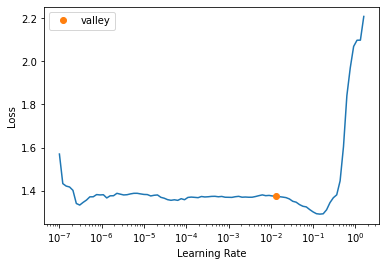

In [24]:
learn.lr_find()

Continue training with suggested learning rate:

In [25]:
learn.fit_one_cycle(10, 0.013)

epoch,train_loss,valid_loss,calculate_metrics,time
0,1.306029,1.185325,-0.199460,00:00
1,1.006230,0.955694,-0.158622,00:00
2,0.903643,0.889402,-0.143719,00:00
3,0.868762,0.883985,-0.145844,00:00
4,0.839710,0.867711,-0.142553,00:00
5,0.816968,0.844202,-0.150993,00:00
6,0.800923,0.831289,-0.151459,00:00
7,0.786995,0.857604,-0.142688,00:00
8,0.761433,0.941798,-0.134945,00:00
9,0.734706,0.847941,-0.143948,00:00


We can loop training until getting a good metrics.

In [ ]:
for i in range(100):
    learn = tabular_learner(dls, [1024, 512, 512, 512, 128], 
                            metrics=AccumMetric(calculate_metrics, dim_argmax=1), 
                            loss_func=CrossEntropyLossFlat(weight=torch.tensor([1.0, 1.0, 2.5, 2.5, 2.5])))
    for _ in range(3):
        l = learn.lr_find(show_plot=False)    
        learn.fit_one_cycle(5, l.valley)

    if learn.final_record[2] > 0.1:
        break

epoch,train_loss,valid_loss,calculate_metrics,time
0,1.548492,1.619150,-0.041866,00:00
1,1.213846,0.973068,-0.148396,00:00
2,0.985269,1.124684,-0.114513,00:00
3,0.876341,0.991833,-0.115600,00:00
4,0.775730,0.961308,-0.090975,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.710169,0.960847,-0.108496,00:00
1,0.706938,0.990376,-0.110020,00:00
2,0.703660,0.972301,-0.114032,00:00
3,0.707180,0.990118,-0.112335,00:00
4,0.704675,0.978482,-0.111231,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.697370,1.006652,-0.132032,00:00
1,0.756894,1.035604,-0.081473,00:00
2,0.718714,1.006923,-0.108746,00:00
3,0.659565,1.055496,-0.109052,00:00
4,0.594999,1.060613,-0.106655,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.544367,1.672461,-0.087263,00:00
1,1.334557,1.207559,-0.081803,00:00
2,1.083999,1.063157,-0.115076,00:00
3,0.908283,0.979911,-0.121390,00:00
4,0.778497,0.968072,-0.125140,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.678218,0.989143,-0.129185,00:00
1,0.680563,1.005323,-0.108498,00:00
2,0.632221,1.027110,-0.135773,00:00
3,0.572886,1.062021,-0.138452,00:00
4,0.532729,1.042144,-0.135021,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.494499,1.056933,-0.137443,00:00
1,0.495515,1.098331,-0.131360,00:00
2,0.478573,1.141321,-0.129210,00:00
3,0.449441,1.123816,-0.124901,00:00
4,0.437885,1.118234,-0.131535,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.597410,1.661848,-0.155515,00:00
1,1.427163,1.325973,-0.083232,00:00
2,1.196381,1.218748,-0.074197,00:00
3,0.991260,1.095116,-0.103822,00:00
4,0.845779,1.061913,-0.109567,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.733488,1.067213,-0.132927,00:00
1,0.732436,1.122901,-0.106038,00:00
2,0.673917,1.093961,-0.147479,00:00
3,0.607408,1.123885,-0.108658,00:00
4,0.543617,1.119126,-0.125492,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.494424,1.111618,-0.106349,00:00
1,0.498425,1.119687,-0.143112,00:00
2,0.470371,1.188826,-0.107906,00:00
3,0.442748,1.182406,-0.129391,00:00
4,0.422371,1.200785,-0.118498,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.631623,1.748869,-0.076126,00:00
1,1.376669,1.263759,-0.084174,00:00
2,1.082958,1.016657,-0.151494,00:00
3,0.898022,1.029457,-0.090873,00:00
4,0.766219,0.990286,-0.136036,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.669638,0.983605,-0.128687,00:00
1,0.665275,1.017656,-0.089770,00:00
2,0.624339,1.025728,-0.087093,00:00
3,0.586403,1.036390,-0.089734,00:00
4,0.549125,1.046408,-0.123931,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.533598,1.068870,-0.095683,00:00
1,0.529520,1.083781,-0.090729,00:00
2,0.519410,1.070504,-0.093921,00:00
3,0.507244,1.081012,-0.091523,00:00
4,0.495948,1.127541,-0.091683,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.488497,2.227709,-0.110580,00:00
1,1.101334,0.948176,-0.089738,00:00
2,0.948640,0.927849,-0.175668,00:00
3,0.872643,0.903135,-0.125134,00:00
4,0.814921,0.937842,-0.102709,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.799644,1.000952,-0.184084,00:00
1,0.845960,1.170527,-0.103574,00:00
2,0.839924,0.952109,-0.080872,00:00
3,0.812225,0.939499,-0.113510,00:00
4,0.769597,0.954468,-0.090632,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.741949,0.941230,-0.093204,00:00
1,0.731908,0.953972,-0.089793,00:00
2,0.733963,0.958725,-0.078837,00:00
3,0.738398,0.937185,-0.104522,00:00
4,0.732650,0.955883,-0.078556,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.590406,1.575141,-0.162929,00:00
1,1.436060,1.408827,-0.119135,00:00
2,1.247247,1.228241,-0.120671,00:00
3,1.061204,1.154126,-0.131549,00:00
4,0.913086,1.136703,-0.136567,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.800452,1.198965,-0.107527,00:00
1,0.846436,1.248351,-0.051110,00:00
2,0.777092,1.092267,-0.137316,00:00
3,0.674142,1.076408,-0.149462,00:00
4,0.569461,1.132279,-0.146393,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.496278,1.109216,-0.136987,00:00
1,0.502089,1.114470,-0.145296,00:00
2,0.493161,1.162145,-0.134424,00:00
3,0.490275,1.148713,-0.150020,00:00
4,0.482025,1.164335,-0.143585,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.566587,1.748865,-0.057604,00:00
1,1.269299,1.065759,-0.115022,00:00
2,1.008672,0.934512,-0.166309,00:00
3,0.867132,0.999655,-0.130499,00:00
4,0.761389,0.964501,-0.133054,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.685692,1.046145,-0.141869,00:00
1,0.744164,1.052122,-0.141941,00:00
2,0.714335,1.041853,-0.102693,00:00
3,0.648591,1.060475,-0.115481,00:00
4,0.569100,1.057825,-0.107973,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.510448,1.057553,-0.120595,00:00
1,0.512401,1.061587,-0.105698,00:00
2,0.504722,1.054888,-0.114042,00:00
3,0.502523,1.050613,-0.102128,00:00
4,0.506574,1.040260,-0.115547,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.603463,1.836891,-0.087671,00:00
1,1.352430,1.282770,-0.075692,00:00
2,1.083354,0.992665,-0.129352,00:00
3,0.905662,1.001920,-0.155682,00:00
4,0.779957,0.985482,-0.150585,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.673827,0.986043,-0.149765,00:00
1,0.675683,0.980002,-0.152479,00:00
2,0.680855,1.014107,-0.156223,00:00
3,0.677736,0.969867,-0.155773,00:00
4,0.668424,0.993389,-0.133330,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.669181,0.975669,-0.142294,00:00
1,0.657871,1.007031,-0.164704,00:00
2,0.619332,1.022799,-0.149618,00:00
3,0.564315,1.061800,-0.148738,00:00
4,0.512217,1.062336,-0.149992,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.574900,1.643781,-0.134809,00:00
1,1.408544,1.337050,-0.099884,00:00
2,1.197839,1.111027,-0.101587,00:00
3,0.999986,1.058022,-0.121023,00:00
4,0.850082,1.066143,-0.140980,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.741652,1.036089,-0.133991,00:00
1,0.722610,1.095334,-0.147364,00:00
2,0.684652,1.118622,-0.114399,00:00
3,0.620454,1.149266,-0.114917,00:00
4,0.565157,1.109343,-0.080471,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.509619,1.130680,-0.099588,00:00
1,0.500197,1.102179,-0.091568,00:00
2,0.495576,1.131119,-0.131535,00:00
3,0.486990,1.173936,-0.101721,00:00
4,0.474579,1.125582,-0.116067,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.516031,1.607749,-0.083685,00:00
1,1.235052,1.098050,-0.050656,00:00
2,1.009046,1.103994,-0.127673,00:00
3,0.876050,0.928969,-0.119055,00:00
4,0.777520,0.929933,-0.136657,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.700859,0.936825,-0.137754,00:00
1,0.700562,0.934138,-0.123141,00:00
2,0.695074,0.923085,-0.102804,00:00
3,0.687618,0.930980,-0.134343,00:00
4,0.680154,0.935681,-0.106494,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.673739,0.974287,-0.113742,00:00
1,0.696743,0.933628,-0.113202,00:00
2,0.657192,0.979103,-0.082526,00:00
3,0.599979,1.028387,-0.103878,00:00
4,0.543971,1.046787,-0.095615,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.525295,1.622087,-0.077029,00:00
1,1.188334,0.982459,-0.173846,00:00
2,0.966352,0.928253,-0.109920,00:00
3,0.851451,1.013118,-0.108372,00:00
4,0.762571,0.965710,-0.110689,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.704528,0.987795,-0.098213,00:00
1,0.760013,0.987800,-0.085217,00:00
2,0.737717,0.988550,-0.097315,00:00
3,0.666801,0.987406,-0.094691,00:00
4,0.600357,0.989050,-0.103674,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.560045,1.115921,-0.096926,00:00
1,0.671780,1.004694,-0.144615,00:00
2,0.632697,1.037464,-0.085651,00:00
3,0.560566,1.112962,-0.085444,00:00
4,0.488757,1.223176,-0.084760,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.585571,1.712711,-0.133086,00:00
1,1.414215,1.304809,-0.147847,00:00
2,1.171191,1.162892,-0.116310,00:00
3,0.982207,1.046404,-0.147188,00:00
4,0.819567,1.033922,-0.127152,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.707945,1.055162,-0.138720,00:00
1,0.730785,1.074522,-0.127645,00:00
2,0.681772,1.063897,-0.115981,00:00
3,0.592451,1.075471,-0.094662,00:00
4,0.509196,1.067837,-0.093942,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.471335,1.097354,-0.114415,00:00
1,0.491771,1.145716,-0.095972,00:00
2,0.459803,1.131859,-0.083236,00:00
3,0.411980,1.168626,-0.106325,00:00
4,0.377958,1.171268,-0.093967,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,1.501113,1.630796,-0.114193,00:00
1,1.122670,0.962871,-0.148071,00:00
2,0.976840,0.954962,-0.152591,00:00
3,0.876063,0.951507,-0.160801,00:00
4,0.811755,0.956118,-0.107953,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.764023,0.967084,-0.143931,00:00
1,0.776719,0.928443,-0.126987,00:00
2,0.760027,0.958351,-0.108699,00:00
3,0.714396,0.980305,-0.113661,00:00
4,0.666867,0.966383,-0.125787,00:00


epoch,train_loss,valid_loss,calculate_metrics,time
0,0.619779,0.973432,-0.108416,00:00
1,0.626555,1.003340,-0.097653,00:00
2,0.606614,1.005697,-0.112871,00:00
3,0.575564,1.073309,-0.101176,00:00


After the model is trained, preparing submission file.

In [167]:
test_predictors = {}
for key, value in data_test.items():
    test_predictors[key] = extract_basic_features(value)

In [168]:
df_test = pd.DataFrame.from_dict(test_predictors, orient="index")
df_test['laterality'] = df_test['laterality'].map(lambda lat: 0 if lat == "L" else 1)

Test data might have colums different from training data:

In [169]:
for elem in df_test.columns:
    if elem not in df_train.columns:
        df_test = df_test.drop([elem], axis=1)

Make sure train and test data have the same number of columns (except for BiRads column).

In [170]:
df_test.shape, df_train.shape

((4663, 269), (4063, 270))

In [171]:
dl = learn.dls.test_dl(df_test)

In [172]:
dl.show_batch()

,tissue_density_predicted,laterality,cancer_probability_predicted,CC_fibrocystic_breast_changes_model_1_max,area_CC_fibrocystic_breast_changes_model_1_max,CC_fibrocystic_breast_changes_model_1_mean,area_CC_fibrocystic_breast_changes_model_1_mean,CC_fibrocystic_breast_changes_model_1_median,area_CC_fibrocystic_breast_changes_model_1_median,CC_fibrocystic_breast_changes_model_1_len,CC_mass_benign_model_1_max,area_CC_mass_benign_model_1_max,CC_mass_benign_model_1_mean,area_CC_mass_benign_model_1_mean,CC_mass_benign_model_1_median,area_CC_mass_benign_model_1_median,CC_mass_benign_model_1_len,CC_mass_benign_model_2_max,area_CC_mass_benign_model_2_max,CC_mass_benign_model_2_mean,area_CC_mass_benign_model_2_mean,CC_mass_benign_model_2_median,area_CC_mass_benign_model_2_median,CC_mass_benign_model_2_len,CC_mass_benign_model_3_max,area_CC_mass_benign_model_3_max,CC_mass_benign_model_3_mean,area_CC_mass_benign_model_3_mean,CC_mass_benign_model_3_median,area_CC_mass_benign_model_3_median,CC_mass_benign_model_3_len,CC_artifact_model_1_max,area_CC_artifact_model_1_max,CC_artifact_model_1_mean,area_CC_artifact_model_1_mean,CC_artifact_model_1_median,area_CC_artifact_model_1_median,CC_artifact_model_1_len,CC_lymphonodus_model_1_max,area_CC_lymphonodus_model_1_max,CC_lymphonodus_model_1_mean,area_CC_lymphonodus_model_1_mean,CC_lymphonodus_model_1_median,area_CC_lymphonodus_model_1_median,CC_lymphonodus_model_1_len,CC_calcinates_benign_model_1_max,area_CC_calcinates_benign_model_1_max,CC_calcinates_benign_model_1_mean,area_CC_calcinates_benign_model_1_mean,CC_calcinates_benign_model_1_median,area_CC_calcinates_benign_model_1_median,CC_calcinates_benign_model_1_len,CC_calcinates_benign_model_2_max,area_CC_calcinates_benign_model_2_max,CC_calcinates_benign_model_2_mean,area_CC_calcinates_benign_model_2_mean,CC_calcinates_benign_model_2_median,area_CC_calcinates_benign_model_2_median,CC_calcinates_benign_model_2_len,CC_calcinates_benign_model_3_max,area_CC_calcinates_benign_model_3_max,CC_calcinates_benign_model_3_mean,area_CC_calcinates_benign_model_3_mean,CC_calcinates_benign_model_3_median,area_CC_calcinates_benign_model_3_median,CC_calcinates_benign_model_3_len,CC_calcified vessels_model_1_max,area_CC_calcified vessels_model_1_max,CC_calcified vessels_model_1_mean,area_CC_calcified vessels_model_1_mean,CC_calcified vessels_model_1_median,area_CC_calcified vessels_model_1_median,CC_calcified vessels_model_1_len,CC_mass_malignant_model_1_max,area_CC_mass_malignant_model_1_max,CC_mass_malignant_model_1_mean,area_CC_mass_malignant_model_1_mean,CC_mass_malignant_model_1_median,area_CC_mass_malignant_model_1_median,CC_mass_malignant_model_1_len,CC_mass_malignant_model_2_max,area_CC_mass_malignant_model_2_max,CC_mass_malignant_model_2_mean,area_CC_mass_malignant_model_2_mean,CC_mass_malignant_model_2_median,area_CC_mass_malignant_model_2_median,CC_mass_malignant_model_2_len,CC_mass_malignant_model_3_max,area_CC_mass_malignant_model_3_max,CC_mass_malignant_model_3_mean,area_CC_mass_malignant_model_3_mean,CC_mass_malignant_model_3_median,area_CC_mass_malignant_model_3_median,CC_mass_malignant_model_3_len,CC_pectoral muscle_model_1_max,area_CC_pectoral muscle_model_1_max,CC_pectoral muscle_model_1_mean,area_CC_pectoral muscle_model_1_mean,CC_pectoral muscle_model_1_median,area_CC_pectoral muscle_model_1_median,CC_pectoral muscle_model_1_len,CC_skin_thickening_model_1_max,area_CC_skin_thickening_model_1_max,CC_skin_thickening_model_1_mean,area_CC_skin_thickening_model_1_mean,CC_skin_thickening_model_1_median,area_CC_skin_thickening_model_1_median,CC_skin_thickening_model_1_len,CC_calcified cyst_model_1_max,area_CC_calcified cyst_model_1_max,CC_calcified cyst_model_1_mean,area_CC_calcified cyst_model_1_mean,CC_calcified cyst_model_1_median,area_CC_calcified cyst_model_1_median,CC_calcified cyst_model_1_len,CC_calcinates_malignant_model_1_max,area_CC_calcinates_malignant_model_1_max,CC_calcinates_malignant_model_1_mean,area_CC_calcinates_malignant_model_1

In [179]:
preds = learn.get_preds(dl=dl, with_decoded=True)

In [180]:
res = preds[2].numpy() + 1

In [181]:
unique, counts = np.unique(res, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   1 1642]
 [   2 1860]
 [   3  416]
 [   4  408]
 [   5  337]]


In [182]:
sub_file = pd.DataFrame.from_dict({'id': df_test.index, 'BiRads': res})

In [183]:
sub_file.head()

,id,BiRads
0,8097d218-2c51-4ec8-9ee8-ea6b7701ef3c,5
1,4c9a6bed-a454-467c-b51e-451f5ee2db35,4
2,2737373f-e0ce-4d58-8d0a-0b85925d1783,2
3,a1298d90-1d62-4a07-a6b4-84999ba8b2c8,2
4,fdcbc6af-8d74-4537-b965-57e91ed77955,5


In [184]:
sub_file.to_csv('submission.csv', index=False)